In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # or the full path to the "project" directory
import numpy as np
import gpbr

In [2]:
from gpbr.direct.common.boundary import Point2D
from gpbr.direct.common.distance import point_distance
def u2de(xp, t):
    point = Point2D(0,4)
    dist =point_distance(point, xp)
    return 1/4/np.pi/t*np.exp(-dist**2/4/t)
    

In [3]:
from gpbr.direct.common.boundary import Point3D
def matf1(X, t: float) -> float:
    return np.zeros_like(X[0])

def matf2(X, t: float) -> float:
    return np.ones_like(X[0]) ## TODO: Add time dependence

In [4]:
from gpbr.direct.heat_equation.common import MFSConfig
T = 1 # final time
N = 7 # N+1=10 time points
# M = 16 # number of collocation and points
M = 32 # number of collocation and points
ETA1 = 0.5
ETA2 = 2.0
config = MFSConfig(
    N=N,
    n_coll=M,
    n_source=M,
    T=T,
    eta1=ETA1,
    eta2=ETA2,
    f1=matf1,
    f2=matf2
)


In [5]:
from gpbr.direct.heat_equation.helpers import precalculate_mfs_data
mfs_data = precalculate_mfs_data(config)

In [6]:
def r2(s):
    return (np.cos(s)**10+np.sin(s)**10)**(-0.1)

def dr2(s):
    term1 = (np.cos(s)**10 + np.sin(s)**10)**(-1.1)
    term2 = np.cos(s) * np.sin(s) * (np.sin(s)**8 - np.cos(s)**8)
    return -1.0 * term1 * term2

# def r2(s):
#     return np.ones_like(s)*0.8


# def dr2(s):
#     return np.zeros_like(s)

In [7]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

from gpbr.direct.common.boundary import StarlikeCurve

def plot_with_normals(Gamma: StarlikeCurve, normal_scale=0.2, show_points=True):
    """
    Plot a 2D starlike curve with its normal vectors.
    
    Parameters:
    -----------
    Gamma : StarlikeCurve
        The curve to plot.
    normal_scale : float, optional
        Scaling factor for normal vector length.
    show_points : bool, optional
        Whether to display points along the curve.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Extract coordinates
    x, y = Gamma.raw_points()
    
    # Plot the curve
    ax.plot(x, y, 'b-', linewidth=2, label='Curve')
    
    # Plot points if requested
    if show_points:
        ax.plot(x, y, 'bo', markersize=4, alpha=0.5)
    
    # Determine which points to show normals for (avoid overcrowding)
    n_points = len(Gamma.points)
    step_size = max(1, n_points // 20)  # Show about 20 normal vectors
    
    # Plot normal vectors
    for i in range(0, n_points, step_size):
        p = Gamma.points[i]
        n = Gamma.normals[i]
        ax.arrow(p.x, p.y, n.x * normal_scale, n.y * normal_scale,
                head_width=normal_scale/5, head_length=normal_scale/3, 
                fc='red', ec='red', width=0.001, 
                length_includes_head=True)
    
    # # Add a quiver plot to the legend
    # ax.quiverkey(
    #     plt.quiver([0], [0], [1], [0], color='red', scale=5),
    #     0.85, 0.05, normal_scale, 'Normal Vector', 
    #     labelpos='E', coordinates='figure'
    # )
    
    # Set axis limits with padding
    all_x = [p.x for p in Gamma.points]
    all_y = [p.y for p in Gamma.points]
    max_extent = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    padding = max_extent * 0.1
    
    ax.set_xlim([min(all_x) - padding, max(all_x) + padding])
    ax.set_ylim([min(all_y) - padding, max(all_y) + padding])
    
    # Set equal aspect ratio to properly visualize angles
    ax.set_aspect('equal')
    
    # Add grid and labels
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title('Curve with Normal Vectors', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

In [8]:
from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))

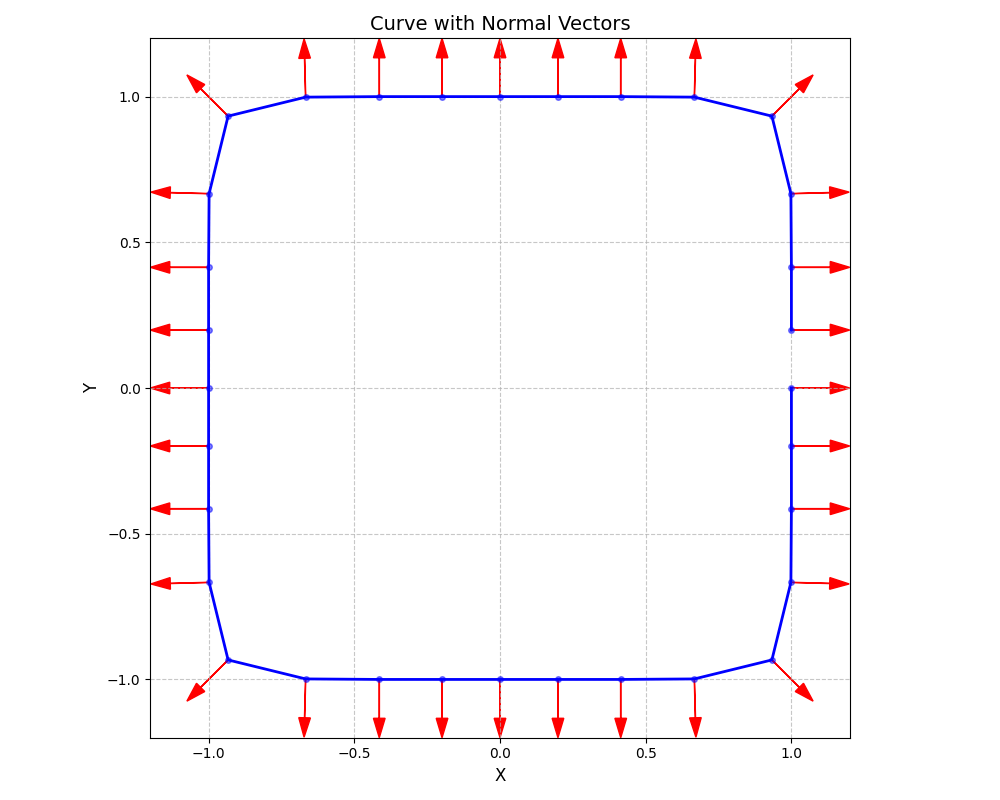

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Curve with Normal Vectors'}, xlabel='X', ylabel='Y'>)

In [9]:
plot_with_normals(Gamma2)

In [10]:
from gpbr.direct.common.source import SourcePoints2D
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence, matfundamental_sequence_2d
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d, matdbu_2d, matform_fs_vector_2d
from gpbr.direct.heat_equation.helpers import dbu_2d

from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs
from numpy.linalg import lstsq


def mateval_for_g1(
        Gamma2: StarlikeCurve,
        Gamma2_source: StarlikeCurve,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeCurve.from_radial(mfs_data.collocation, r1_func)
    Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1_func(s))
    source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = matfundamental_sequence_2d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = matfundamental_sequence_2d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)

    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = matform_fs_vector_2d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        try:
            alpha_n = lstsq(PHI_MAT, F)[0]
        except np.linalg.LinAlgError:
            print("Failed to solve the linear system")
            return None
        fs_coefs.alpha[n] = alpha_n.T

    # print(fs_coefs.alpha)

    du_vals = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    du_vals[:] = np.nan

    for ni in range(0, N+1):
        du_vals[ni] = matdbu_2d(Gamma2.points_array,Gamma2.normals_array, ni, source_points, fs_coefs, mfs_data).ravel()
    return du_vals


    

In [11]:

# def r1(s):
#     return 0.45*np.sqrt(np.cos(s)**2 + np.sin(s)**2/4)

def r1(s):
    return (1+0.9*np.cos(s) + 0.1*np.sin(2*s))/(2+1.5*np.cos(s))

exact = mateval_for_g1(Gamma2, Gamma2_source, matf1, matf2, mfs_data, r1)

In [12]:
exact

array([[ 4.10003575,  3.87014075,  3.45935427,  1.90525042,  3.46117181,
         3.85459207,  4.06329137,  4.15055522,  4.02255399,  3.79318054,
         3.40513475,  1.90346837,  3.40671572,  3.76460854,  3.95830423,
         4.06077882,  3.97249109,  3.78697716,  3.42604902,  1.90111938,
         3.42955672,  3.82223994,  4.04260771,  4.14957165,  4.0412219 ,
         3.82305991,  3.43460287,  1.9086844 ,  3.43398411,  3.8402012 ,
         4.07977916,  4.20403283],
       [ 0.45888019,  0.21693274, -0.72161109, -0.69488284, -0.71558543,
         0.16446015,  0.33653584,  0.22356342,  0.17676002, -0.08380112,
        -0.94244323, -0.71657907, -0.94241826, -0.19940982, -0.06950289,
        -0.11264198, -0.00474966, -0.0972116 , -0.85436952, -0.71898758,
        -0.84014676,  0.04069391,  0.26396055,  0.22972944,  0.26194496,
         0.0494884 , -0.81387315, -0.69044998, -0.81365188,  0.10749753,
         0.38708726,  0.4064718 ],
       [ 2.82100375,  2.23638397,  2.08829266,  0.9448

In [13]:
import numpy as np

def noise(vals, noise_level=0.01, seed=None):
    """
    Add static noise to the input values with a specified noise level.
    
    Parameters:
    -----------
    vals : numpy.ndarray
        Input array to which noise will be added.
    noise_level : float, optional
        The noise level, determining the magnitude of the random noise.
    seed : int, optional
        Seed for the random number generator to produce static noise.
        
    Returns:
    --------
    numpy.ndarray
        The input array with added noise.
    """
    if seed is not None:
        # Use a temporary random seed
        state = np.random.get_state()  # Save the current random state
        np.random.seed(seed)          # Set the seed
        random_noise = noise_level * np.random.uniform(low=-1.0,high=1.0,size=vals.shape)
        np.random.set_state(state)    # Restore the original random state
    else:
        # Generate noise without setting a seed
        random_noise = noise_level * np.random.uniform(low=-1.0,high=1.0,size=vals.shape)
    
    return vals * (1 + random_noise)
    # if seed is not None:
    #     # Use a temporary random seed
    #     state = np.random.get_state()  # Save the current random state
    #     np.random.seed(seed)          # Set the seed
    #     random_noise = noise_level * np.random.uniform(low=0.0,high=1.0,size=vals.shape)
    #     np.random.set_state(state)    # Restore the original random state
    # else:
    #     # Generate noise without setting a seed
    #     random_noise = noise_level * np.random.uniform(low=0.0,high=1.0,size=vals.shape)
    
    # return vals * (1 + random_noise)

In [14]:
exact = noise(exact, 0.03, seed=495882730)

In [15]:
import matplotlib.pyplot as plt

# def plot_g1(G1):
#     fig_plot, ax_plot = plt.subplots()
#     g1_x, g1_y = G1.raw_points()
#     ax_plot.plot(g1_x, g1_y, 'b--')

#     ax_plot.axis('equal')
#     plt.grid()
#     plt.show()
#     plt.close()

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_g1(G1, title="Starlike Curve", show_normals=False, color='#1f77b4', 
            figsize=(10, 8), dpi=120, save_path=None):
    """
    Plot a starlike curve with enhanced visual presentation.
    
    Parameters:
    -----------
    G1 : StarlikeCurve
        The starlike curve to plot.
    title : str, optional
        Title for the plot.
    show_normals : bool, optional
        Whether to display normal vectors.
    color : str, optional
        Color for the curve.
    figsize : tuple, optional
        Figure size (width, height) in inches.
    dpi : int, optional
        Resolution of the figure.
    save_path : str, optional
        If provided, save the figure to this path.
    """
    # Set up the figure with clean style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Get points and plot with enhanced styling
    g1_x, g1_y = G1.raw_points()
    
    # Plot filled curve with fade
    ax.fill(g1_x, g1_y, color=color, alpha=0.2)
    
    # Plot curve with solid color instead of gradient
    ax.plot(g1_x, g1_y, color=color, linewidth=2.5, alpha=0.8)
    
    # Add a few markers along the curve
    num_markers = 12
    marker_indices = np.linspace(0, len(g1_x)-1, num_markers, dtype=int)
    ax.plot(g1_x[marker_indices], g1_y[marker_indices], 'o', color='navy', 
            markersize=5, alpha=0.8)
    
    # Show normals if requested
    if show_normals and hasattr(G1, 'normals'):
        for i in marker_indices:
            if i < len(G1.points):  # Ensure index is valid
                p = G1.points[i]
                n = G1.normals[i]
                ax.arrow(p.x, p.y, n.x*0.15, n.y*0.15, head_width=0.05, 
                         head_length=0.08, fc='red', ec='red', alpha=0.7)
    
    # Enhance the appearance
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)
    
    # Add legend if showing normals
    if show_normals:
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color=color, lw=2, label='Curve'),
            Line2D([0], [0], marker='o', color='navy', label='Sample Points', 
                  markersize=5, linestyle='None'),
            Line2D([0], [0], color='red', label='Normal Vectors')
        ]
        ax.legend(handles=legend_elements, loc='best')
    
    # Calculate max radius for setting limits
    max_radius = max(np.sqrt(g1_x**2 + g1_y**2))
    
    # Adjust limits with padding
    padding = max_radius * 0.1
    ax.set_xlim([-max_radius-padding, max_radius+padding])
    ax.set_ylim([-max_radius-padding, max_radius+padding])
    
    # Tight layout
    plt.tight_layout()
    
    # Save if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()
    
    return fig, ax

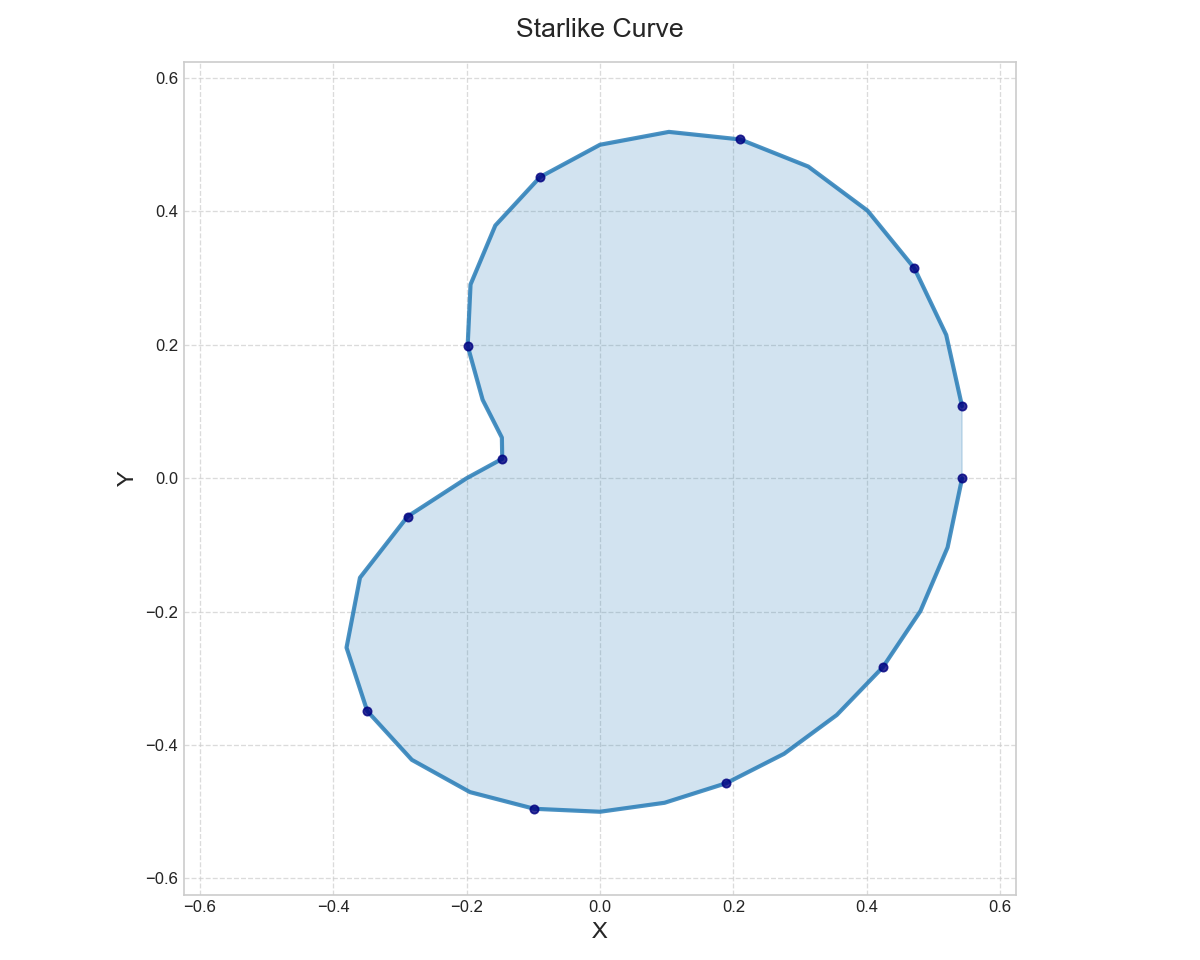

(<Figure size 1200x960 with 1 Axes>,
 <Axes: title={'center': 'Starlike Curve'}, xlabel='X', ylabel='Y'>)

In [16]:
G1_plot = StarlikeCurve.from_radial(mfs_data.collocation, r1)
plot_g1(G1_plot)

In [17]:
from scipy import integrate

def calc_l2_norm(ncoll, thetas, tn, exact, approx):
    return np.linalg.norm(approx-exact)
    diff_squared = (approx-exact)**2
    time_inegrals = []
    for i in range(len(tn)):
        time_inegrals.append(integrate.trapezoid(diff_squared[i], thetas))
    
    return integrate.trapezoid(time_inegrals, tn)
    # return np.sqrt(integrate.trapezoid(np.sum((approx-exact)**2, axis=1), tn)*(2*np.pi)/(ncoll))
    return integrate.trapezoid(np.sum((approx-exact)**2, axis=1), tn)*(2*np.pi)/(ncoll)


In [18]:
def feasable(ext_boundary, rfunc, rvals):
    if abs(rfunc(0) - rfunc(2*np.pi)) > 1e-10:
        return False

    if not np.isfinite(rvals).all():
        return False

    if np.any(np.less(rvals, 0.0)):
        return False

    if np.any(np.greater_equal(rvals, ext_boundary)):
        return False
    
    return True

In [19]:
import random
from deap import creator, base, tools, algorithms, gp

In [20]:
def protected_div(numerator, denominator):
    """
    Protected division function to avoid division by zero errors.
    
    Parameters:
    -----------
    numerator : float or numpy.ndarray
        The numerator in the division
    denominator : float or numpy.ndarray
        The denominator in the division
        
    Returns:
    --------
    result : float or numpy.ndarray
        The division result, with 1.0 returned where denominator == 0
    """
    # Handle scalar values
    if isinstance(denominator, (int, float)):
        return numerator / denominator if abs(denominator) > 1e-10 else 1.0
        
    # Handle numpy arrays
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.divide(numerator, denominator)
        if isinstance(result, np.ndarray):
            result[np.isinf(result)] = 1.0
            result[np.isnan(result)] = 1.0
            return result
        elif np.isinf(result) or np.isnan(result):
            return 1.0
        return result

In [21]:
import functools
import math, operator

pset = gp.PrimitiveSet("main", 1)
pset.addPrimitive(np.add, 2)
# pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addPrimitive(np.sqrt, 1)
# pset.addPrimitive(np.abs, 1)
# pset.addPrimitive(protected_div, 2)
pset.addEphemeralConstant('rand', (np.random.rand, 1)[0])
# pset.addTerminal(np.pi, 'pi')

pset.renameArguments(ARG0="s")

In [22]:
import random
from deap import creator, base, tools, algorithms
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [23]:
toolbox = base.Toolbox()
# toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=3, max_=6)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

In [24]:
# toolbox.register('evaluate', eval_for_g1, Gamma2=Gamma2, Gamma2_source=Gamma2_source, f1=f1, f2=f2, mfs_data=mfs_data)
# toolbox.register('feasable', feasable, 0.8)
toolbox.register('feasable', feasable, 1.0)
toolbox.register('calc_normals', mateval_for_g1, Gamma2, Gamma2_source, matf1, matf2, mfs_data)
toolbox.register('norm', calc_l2_norm, mfs_data.M,mfs_data.collocation.theta, mfs_data.tn, exact)
toolbox.register('plot', plot_g1)

In [25]:
def evaluate(mfsd, tlb, ind):
    # print(ind)
    ind_compile = tlb.compile(expr=ind)
    ind_values = ind_compile(mfsd.collocation.theta)
    if not toolbox.feasable(ind_compile, ind_values):
        return (1e6, )

    g2_approx = toolbox.calc_normals(ind_compile)
    if g2_approx is None:
        print("Failed to calculate g2_approx for individual :", ind)
        return (1e6, )
    return (toolbox.norm(g2_approx), )

In [26]:
toolbox.register('evaluate', evaluate, mfs_data, toolbox)

In [27]:
def random_operator(options):
    return random.choice(options)

In [ ]:
def cxLinearCombination(ind1, ind2, pset):

    for p in ['multiply', 'add']:
        assert p in pset.mapping, "A '" + p + "' function is required in order to perform semantic crossover"
    index1 = random.randint(0, len(ind1) - 1)
    index2 = random.randint(0, len(ind2) - 1)

    subtree1_slice = ind1.searchSubtree(index1)
    subtree2_slice = ind2.searchSubtree(index2)
    r = random.random()

    tr = gp.PrimitiveTree([])
    tr.insert(0, pset.mapping['multiply'])
    tr.append(gp.Terminal(r, False, object))
    tr.extend(ind1[subtree1_slice])
    tr.insert(0, pset.mapping['add'])
    tr.append(pset.mapping['multiply'])
    tr.append(gp.Terminal(1.0-r, False, object))
    tr.extend(ind2[subtree2_slice])

    ind1[subtree1_slice] = tr
    ind2[subtree2_slice] = tr
    return ind1, ind2


    
    # new_ind1 = ind1
    # new_ind1.insert(0, pset.mapping["mul"])
    # new_ind1.insert(0, pset.mapping["add"])
    # new_ind1.extend(tr)
    # new_ind1.append(pset.mapping["mul"])
    # new_ind1.append(pset.mapping["sub"])
    # new_ind1.append(Terminal(1.0, False, object))
    # new_ind1.extend(tr)
    # new_ind1.extend(ind2)

    # new_ind2 = ind2
    # new_ind2.insert(0, pset.mapping["mul"])
    # new_ind2.insert(0, pset.mapping["add"])
    # new_ind2.extend(tr)
    # new_ind2.append(pset.mapping["mul"])
    # new_ind2.append(pset.mapping["sub"])
    # new_ind2.append(Terminal(1.0, False, object))
    # new_ind2.extend(tr)
    # new_ind2.extend(ind1)

    # return new_ind1, new_ind2


In [ ]:
# toolbox.register("select", tools.selTournament, tournsize=3)
# toolbox.register("select", tools.selBest)
# toolbox.register("select", tools.selTournament, tournsize=4)
# toolbox.register("select", tools.selDoubleTournament, fitness_size=3, fitness_first=False, parsimony_size=1.4)
# toolbox.register("select", tools.selNSGA2)
# toolbox.register("select", tools.selLexicase)
toolbox.register("select", tools.selAutomaticEpsilonLexicase)

# toolbox.register("mate", gp.cxOnePoint)
# toolbox.register("expr_mut", gp.genFull, min_=0, max_=3)
# toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)



toolbox.register("mate_onepoint", gp.cxOnePoint)
toolbox.register("mate_lincomb", cxLinearCombination, pset=pset)
toolbox.register("mate_leaf_based", gp.cxOnePointLeafBiased, termpb=0.35)
mate_operators = [toolbox.mate_lincomb, toolbox.mate_onepoint, toolbox.mate_leaf_based]
# mate_operators = [toolbox.mate_lincomb]

toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
toolbox.register("mutate_ephemeral", gp.mutEphemeral, mode="one")
toolbox.register("mutate_insert", gp.mutInsert, pset=pset)
toolbox.register("mutate_shrink", gp.mutShrink)
# toolbox.register("mutate_shift", mutate_angular_shift, pset=pset)
# toolbox.register("mutate_shrink", gp.mutShrink)
mutate_operators = [toolbox.mutate_uniform, toolbox.mutate_node_replacement, toolbox.mutate_ephemeral, toolbox.mutate_insert, toolbox.mutate_shrink]


toolbox.register("mate", random.choice(mate_operators))
toolbox.register("mutate", random.choice(mutate_operators))

# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [30]:

# random.seed(318)

pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)
# pop[1] = creator.Individual(gp.PrimitiveTree.from_string(
#                     'add(multiply(add(add(sin(s), add(multiply(cos(s), cos(add(add(cos(s), sqrt(cos(sqrt(sqrt(add(0.0013364073803701082, 0.0013364073803701082)))))), s))), sqrt(add(add(multiply(cos(s), cos(add(cos(sin(add(sin(0.04005645921529977), 0.1394320008385148))), s))), sqrt(add(add(add(0.29088284438006773, add(add(multiply(0.04005645921529977, 0.0013364073803701082), sqrt(sqrt(0.29088284438006773))), cos(sin(cos(sin(0.1394320008385148)))))), sin(0.04005645921529977)), sin(multiply(cos(s), cos(add(add(cos(add(s, 0.4596194466715766)), cos(sin(0.1394320008385148))), s))))))), sin(s))))), add(cos(sqrt(add(cos(cos(add(s, cos(cos(sin(s)))))), add(cos(cos(add(cos(add(cos(sqrt(sqrt(add(0.0013364073803701082, 0.1394320008385148)))), s)), add(cos(sqrt(0.04005645921529977)), sin(add(sin(0.04005645921529977), 0.1394320008385148)))))), cos(add(cos(cos(add(cos(add(add(cos(0.04005645921529977), 0.0013364073803701082), s)), sqrt(cos(0.28249720574075066))))), s)))))), add(cos(sqrt(add(cos(s), add(cos(cos(add(cos(sin(add(sin(cos(s)), sin(s)))), s))), cos(cos(sin(s))))))), sin(s)))), multiply(multiply(cos(s), sin(sin(sin(0.04005645921529977)))), add(cos(sin(sin(0.04005645921529977))), 0.1394320008385148))), sin(sqrt(cos(sqrt(add(add(cos(sqrt(sqrt(add(sin(0.0013364073803701082), 0.1394320008385148)))), cos(cos(cos(cos(cos(sin(0.1394320008385148))))))), 0.08563657677507353))))))',
#                     pset=pset))
# pop[1] = creator.Individual(gp.PrimitiveTree.from_string(
#                         'sqrt(multiply(sqrt(multiply(multiply(multiply(0.25208230615048755, cos(multiply(cos(s), cos(add(multiply(cos(0.6294243801834296), add(cos(s), sin(s))), 0.670563213380534))))), cos(cos(add(multiply(cos(add(s, cos(add(cos(s), 0.670563213380534)))), cos(add(multiply(cos(cos(add(s, add(s, s)))), cos(cos(0.670563213380534))), 0.670563213380534))), cos(cos(add(s, 0.670563213380534))))))), cos(multiply(cos(s), cos(add(multiply(cos(sqrt(multiply(cos(0.2643119933317818), cos(cos(cos(s)))))), cos(s)), 0.670563213380534)))))), sqrt(multiply(sqrt(multiply(multiply(0.25208230615048755, cos(multiply(cos(s), cos(add(multiply(cos(0.6294243801834296), add(cos(s), sin(s))), 0.670563213380534))))), cos(cos(add(s, 0.670563213380534))))), cos(cos(add(cos(s), cos(cos(add(s, cos(add(cos(s), cos(s)))))))))))))',
#                         pset=pset))
# pop[1] = creator.Individual(gp.PrimitiveTree.from_string(
#     "sin(sin(add(0.5073706115384214, multiply(0.06672514072511515, add(multiply(sin(s), cos(s)), add(multiply(0.8726961718459537, add(multiply(sin(multiply(0.9487955572997007, add(cos(add(add(cos(add(s, 0.8726961718459537)), 0.06672514072511515), 0.8726961718459537)), 0.06672514072511515))), cos(s)), add(multiply(0.06672514072511515, multiply(0.9487955572997007, add(0.9487955572997007, 0.4178318122983534))), multiply(sin(sin(sqrt(sqrt(0.4495260847741741)))), add(multiply(sin(s), cos(s)), add(multiply(sin(sin(sqrt(sqrt(0.4495260847741741)))), cos(s)), add(cos(s), 0.04394842899275764))))))), cos(add(s, multiply(0.9487955572997007, add(multiply(0.9487955572997007, add(cos(add(s, 0.8726961718459537)), 0.06672514072511515)), 0.4178318122983534))))))))))",
#                         pset=pset))
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.1, 200, stats=mstats,
#                             halloffame=hof, verbose=True)

# MU, LAMBDA = 100, 200
MU, LAMBDA = 200, 400
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
                                            cxpb=0.7, mutpb=0.3, ngen=100, 
                                            stats=mstats, halloffame=hof)

<string>:1: RuntimeWarning: invalid value encountered in sqrt


   	      	                   fitness                    	                      size                     
   	      	----------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max  	min    	nevals	std   	avg   	gen	max	min	nevals	std    
0  	1000  	826007	0  	1e+06	2.84527	1000  	379094	12.735	0  	68 	4  	1000  	8.34139
1  	400   	2.84527	1  	2.84527	2.84527	400   	0     	4     	1  	4  	4  	400   	0      
2  	400   	2.84495	2  	2.84554	2.84183	400   	0.00093048	6.455 	2  	13 	4  	400   	3.51539
3  	400   	2.84558	3  	2.86488	2.8418 	400   	0.00352671	8.815 	3  	27 	4  	400   	5.05774
4  	400   	2.77161	4  	2.77161	2.77161	400   	4.44089e-16	29    	4  	29 	29 	400   	0      
5  	400   	2.5905 	5  	2.59397	2.58603	400   	0.00264702 	38.105	5  	45 	31 	400   	5.68014
6  	400   	2.04507	6  	2.04507	2.04507	400   	4.44089e-16	32    	6  	32 	32 	400   	0      
7  	400   	1.72229	7  	1.75142	1.69298	400   	0.0190551  	39.915	7  	52 	38

In [31]:
print("Best individual is: ", hof[0])

Best individual is:  add(multiply(0.7742900693492611, sin(add(multiply(0.8770607984389658, sin(sin(0.5535420566777092))), multiply(0.12293920156103422, add(multiply(0.2746645322090976, add(add(multiply(0.08992199776183307, add(multiply(0.26238156410351887, multiply(0.49016440903133796, sin(0.5535420566777092))), multiply(0.7376184358964811, add(multiply(0.2834315176170905, 0.12293920156103422), multiply(0.7165684823829095, multiply(0.9012269860427943, 0.04014593451070303)))))), multiply(add(multiply(0.4152069374312256, 0.9100780022381669), multiply(0.5847930625687744, multiply(0.2834315176170905, 0.12293920156103422))), multiply(0.44693252856917254, 0.12293920156103422))), multiply(add(0.7725408355896416, cos(0.509835590968662)), add(multiply(add(add(multiply(0.09877301395720572, multiply(0.3206128120026628, add(multiply(0.7419897628355747, 0.8770607984389658), multiply(0.2580102371644253, 0.22638064144779546)))), multiply(0.9012269860427943, 0.04014593451070303)), multiply(0.679387187

In [32]:
# from deap import gp

# def simplify_individual(individual, pset, arg_name="s"):
#     """
#     Simplify a GP individual by replacing subtrees with constant values
#     where the specified argument is not present.

#     Parameters:
#     -----------
#     individual : deap.gp.PrimitiveTree
#         The GP individual to simplify.
#     pset : deap.gp.PrimitiveSet
#         The primitive set used in the GP.
#     arg_name : str, optional
#         The name of the argument to check for (default is "ARG0").

#     Returns:
#     --------
#     deap.gp.PrimitiveTree
#         A simplified version of the individual.
#     """
#     def contains_argument(subtree):
#         """Check if the subtree contains the specified argument."""
#         return any(str(node) == arg_name for node in subtree)

#     # Traverse the tree and simplify subtrees
#     for i, node in enumerate(individual):
#         if isinstance(node, gp.Primitive):
#             # Get the subtree rooted at the current node
#             subtree_slice = individual.searchSubtree(i)
#             subtree = individual[subtree_slice]

#             # Check if the subtree contains the argument
#             if not contains_argument(subtree):
#                 # Evaluate the subtree and replace it with a constant
#                 try:
#                     compiled_subtree = gp.compile(subtree, pset)
#                     constant_value = compiled_subtree(0)  # Evaluate with a dummy input
#                     individual[subtree_slice] = [gp.Terminal(constant_value, False, type(constant_value))]
#                 except Exception:
#                     # If evaluation fails, keep the original subtree
#                     pass

#     return individual

In [33]:
def plot_exact_and_approx(exact_curve, approx_curve, title="Exact vs. Approximate Solution"):
    """
    Plot exact and approximate curves with error visualization.
    
    Parameters:
    -----------
    exact_curve : StarlikeCurve
        The exact solution curve
    approx_curve : StarlikeCurve
        The approximate solution curve
    title : str
        Main title for the plots
        
    Returns:
    --------
    figs : tuple
        Tuple containing the two figure objects
    """
    # Create two separate figures
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    fig2, ax2 = plt.subplots(figsize=(10, 8))
    
    # Get data points
    exact_x, exact_y = exact_curve.raw_points()
    approx_x, approx_y = approx_curve.raw_points()
    
    # Calculate errors at each point
    exact_r = np.sqrt(exact_x**2 + exact_y**2)
    approx_r = np.sqrt(approx_x**2 + approx_y**2)
    abs_error = np.abs(exact_r - approx_r)
    max_error = np.max(abs_error)
    
    # FIGURE 1: Side-by-side comparison
    # Plot exact curve
    ax1.plot(exact_x, exact_y, color='green', linewidth=3, label='Exact')
    ax1.fill(exact_x, exact_y, color='green', alpha=0.2)
    
    # Plot approximate curve
    ax1.plot(approx_x, approx_y, color='red', linewidth=3, label='Approximate')
    ax1.fill(approx_x, approx_y, color='red', alpha=0.2)
    
    # Add markers for better visualization
    num_markers = 8
    marker_indices = np.linspace(0, len(exact_x)-1, num_markers, dtype=int)
    ax1.plot(exact_x[marker_indices], exact_y[marker_indices], 'o', 
             color='darkgreen', markersize=5)
    ax1.plot(approx_x[marker_indices], approx_y[marker_indices], 'o', 
             color='darkred', markersize=5)
    
    # Figure 1 styling
    ax1.set_aspect('equal')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_title(f"{title}\nComparison View", fontsize=14)
    ax1.set_xlabel('X', fontsize=12)
    ax1.set_ylabel('Y', fontsize=12)
    ax1.legend(loc='best')
    
    # FIGURE 2: Error visualization
    # Plot exact curve as reference
    ax2.plot(exact_x, exact_y, color='black', linewidth=2, linestyle='--', 
             alpha=0.7, label='Exact')
    
    # Create a colormap for the error
    norm = plt.Normalize(0, max_error)
    
    # Plot approximate curve colored by error
    # We'll use a LineCollection for coloring by error value
    from matplotlib.collections import LineCollection
    points = np.array([approx_x, approx_y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap='jet', norm=norm, linewidth=4)
    lc.set_array(abs_error)
    line = ax2.add_collection(lc)
    
    # Add a colorbar
    cbar = fig2.colorbar(line, ax=ax2)
    cbar.set_label('Absolute Error')
    
    # Figure 2 styling
    ax2.set_aspect('equal')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_title(f"{title}\nError Visualization", fontsize=14)
    ax2.set_xlabel('X', fontsize=12)
    ax2.set_ylabel('Y', fontsize=12)
    
    # Set axis limits for both plots based on the maximum extent
    max_radius = max(
        np.max(np.sqrt(exact_x**2 + exact_y**2)),
        np.max(np.sqrt(approx_x**2 + approx_y**2))
    )
    padding = max_radius * 0.4
    
    for ax in [ax1, ax2]:
        ax.set_xlim([-max_radius-padding, max_radius+padding])
        ax.set_ylim([-max_radius-padding, max_radius+padding])
    
    # Create a custom legend for the second plot
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linestyle='--', lw=2, label='Exact Curve'),
        Line2D([0], [0], color='red', lw=2, label='Approximate (Error Colored)')
    ]
    ax2.legend(handles=legend_elements, loc='best')
    
    # Apply tight layout
    fig1.tight_layout()
    fig2.tight_layout()
    
    plt.show()
    
    return (fig1, fig2)

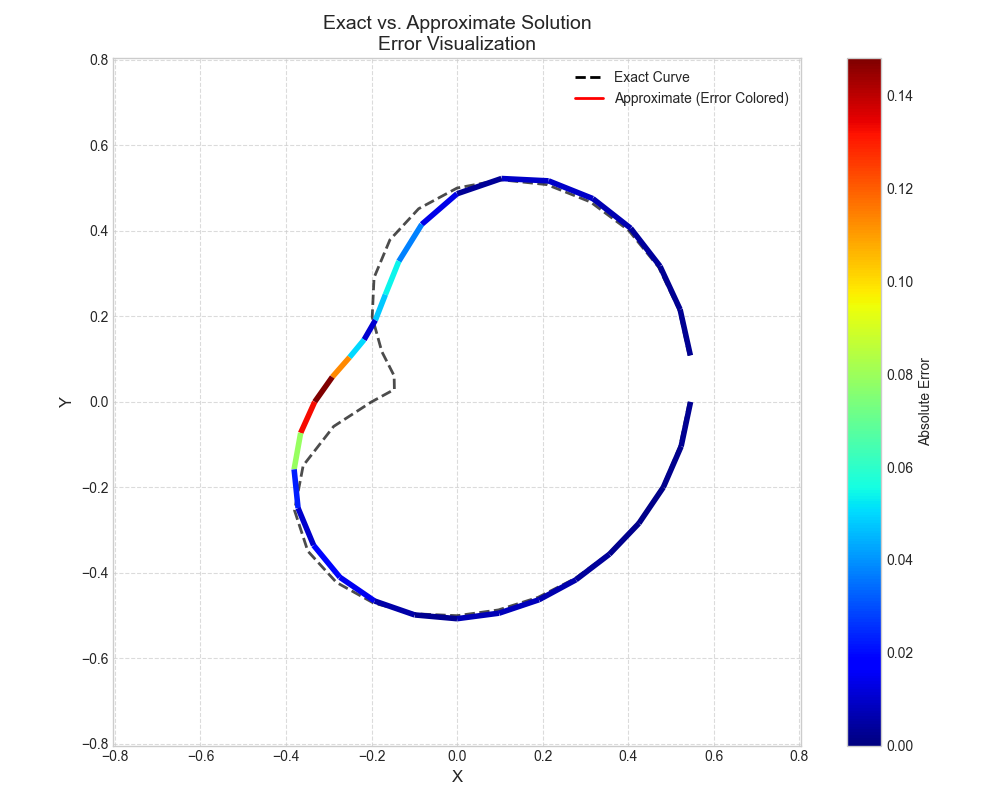

(<Figure size 1000x800 with 1 Axes>, <Figure size 1000x800 with 2 Axes>)

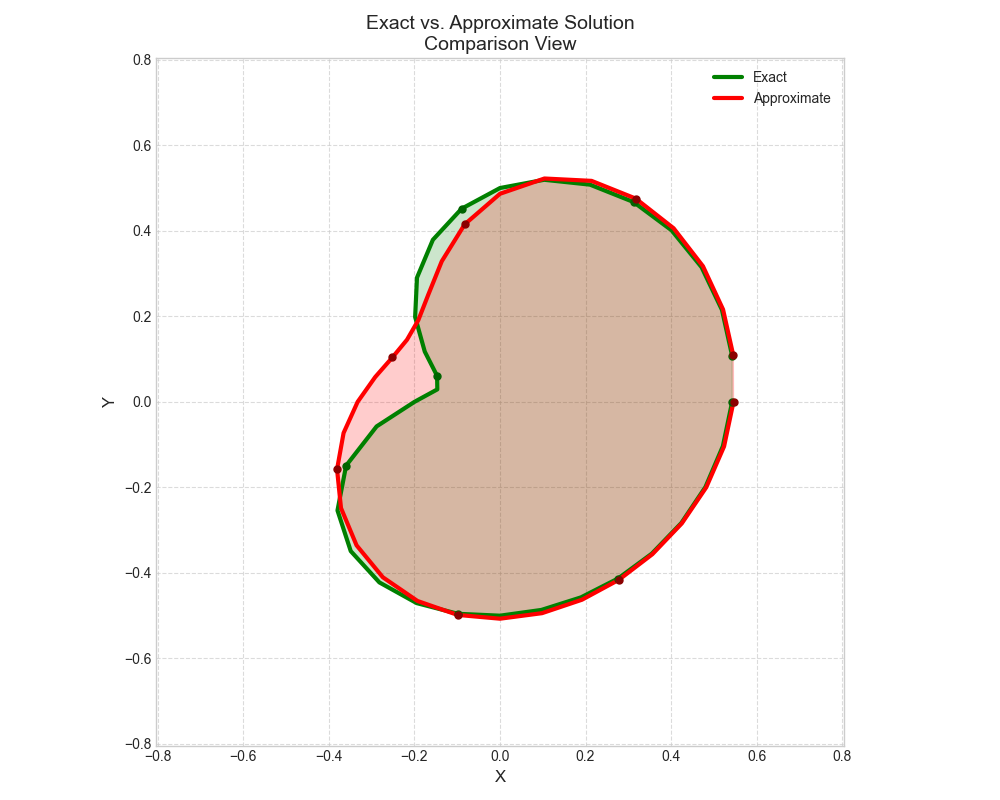

In [34]:

G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
plot_exact_and_approx(G1_plot, G1_test, title="Exact vs. Approximate Solution")

In [35]:
def plot_both(exact_rfunc, approx_rfunc, outter_rfun, n_theta=256, title="Exact vs. Approximate Solution"):
    """
    Plot exact and approximate curves with enhanced colors and styling.
    
    Parameters:
    -----------
    exact_rfunc : function
        Function for the exact solution radius
    approx_rfunc : function
        Function for the approximate solution radius
    outter_rfun : function
        Function for the outer boundary radius
    n_theta : int
        Number of points for plotting (resolution)
    title : str
        Main title for the plot
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure object containing the plot
    """
    # Create figure
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    thetas = np.linspace(0, 2*np.pi, n_theta)

    # Calculate radius values
    exact_rvals = exact_rfunc(thetas)
    approx_rvals = approx_rfunc(thetas)
    outter_rvals = outter_rfun(thetas)

    # Convert to cartesian coordinates
    xx = np.cos(thetas)
    yy = np.sin(thetas)

    exact_x = exact_rvals * xx
    exact_y = exact_rvals * yy

    approx_x = approx_rvals * xx
    approx_y = approx_rvals * yy

    outter_x = outter_rvals * xx
    outter_y = outter_rvals * yy

    # Plot with enhanced styling
    # Outer boundary - use a warm color (orange)
    ax1.plot(outter_x, outter_y, color='#FF8C00', linewidth=2.5, label='Outer Boundary',
             linestyle='-', alpha=0.8)
    # ax1.fill(outter_x, outter_y, color='#FF8C00', alpha=0.1)
    
    # Exact solution - use a distinct blue
    ax1.plot(exact_x, exact_y, color='#1E88E5', linestyle='--', linewidth=3, 
             label='Exact Solution', alpha=0.9)
    # ax1.fill(exact_x, exact_y, color='#1E88E5', alpha=0.1)
    
    # Approximation - use a vibrant purple
    ax1.plot(approx_x, approx_y, color='#8E24AA', linewidth=3, label='Approximation')
    # ax1.fill(approx_x, approx_y, color='#8E24AA', alpha=0.15)
    
    # Figure styling
    ax1.set_aspect('equal')
    ax1.grid(True, linestyle='--', alpha=0.6)
    # ax1.set_title(f"{title}", fontsize=15, pad=15)
    ax1.set_xlabel('X', fontsize=13)
    ax1.set_ylabel('Y', fontsize=13)
    
    # Add legend with custom ordering (to match the visual layering)
    handles, labels = ax1.get_legend_handles_labels()
    order = [2, 0, 1]  # Reorder to: Outer, Exact, Approx
    ax1.legend([handles[i] for i in order], [labels[i] for i in order], 
               loc='best', framealpha=0.9, fontsize=12)
    
    # Set axis limits based on the maximum extent
    max_radius = max(
        np.max(np.sqrt(exact_x**2 + exact_y**2)),
        np.max(np.sqrt(approx_x**2 + approx_y**2)),
        np.max(np.sqrt(outter_x**2 + outter_y**2)),
    )
    # padding = max_radius * 0.15
    padding = max_radius * 0.15
    
    ax1.set_xlim([-max_radius-padding, max_radius+padding])
    ax1.set_ylim([-max_radius-padding, max_radius+padding])
    
    # Apply tight layout
    fig1.tight_layout()
    
    plt.show()
    
    return fig1

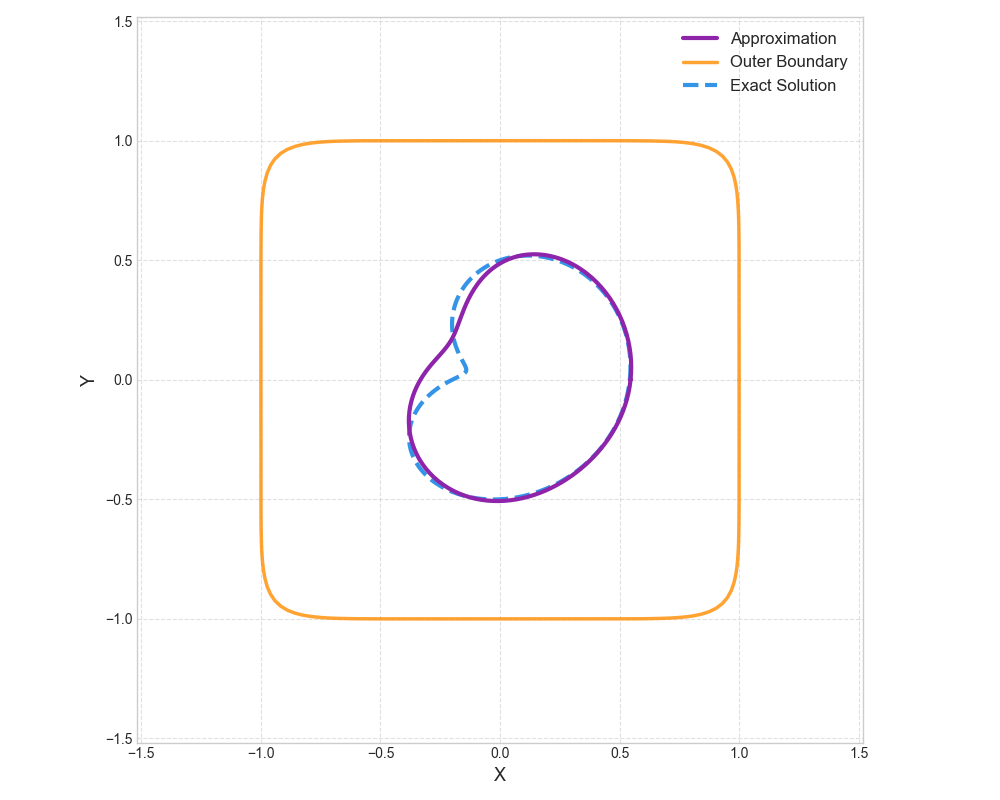

In [36]:
fig_reconsructed = plot_both(r1, toolbox.compile(expr=hof[0]), r2)

# You can save each figure separately
fig_reconsructed.savefig('./results/2d_2_reconstructed.png', dpi=300, transparent=True)


In [37]:
fig_reconsructed.savefig('./results/2d_2_reconstructed.png', dpi=300, transparent=True)

In [38]:
# G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
# toolbox.plot(G1_test)

In [39]:
print(hof[0])

add(multiply(0.7742900693492611, sin(add(multiply(0.8770607984389658, sin(sin(0.5535420566777092))), multiply(0.12293920156103422, add(multiply(0.2746645322090976, add(add(multiply(0.08992199776183307, add(multiply(0.26238156410351887, multiply(0.49016440903133796, sin(0.5535420566777092))), multiply(0.7376184358964811, add(multiply(0.2834315176170905, 0.12293920156103422), multiply(0.7165684823829095, multiply(0.9012269860427943, 0.04014593451070303)))))), multiply(add(multiply(0.4152069374312256, 0.9100780022381669), multiply(0.5847930625687744, multiply(0.2834315176170905, 0.12293920156103422))), multiply(0.44693252856917254, 0.12293920156103422))), multiply(add(0.7725408355896416, cos(0.509835590968662)), add(multiply(add(add(multiply(0.09877301395720572, multiply(0.3206128120026628, add(multiply(0.7419897628355747, 0.8770607984389658), multiply(0.2580102371644253, 0.22638064144779546)))), multiply(0.9012269860427943, 0.04014593451070303)), multiply(0.6793871879973372, multiply(0.1

In [40]:
def plot_evolution_stats(log, title="Evolutionary Algorithm Performance", figsize=(10, 6)):
    """
    Visualize the evolutionary process based on DEAP's MultiStatistics log,
    with each metric on a separate figure.
    
    Parameters:
    -----------
    log : DEAP logbook
        The logbook returned by DEAP's algorithms (eaSimple, eaMuPlusLambda, etc.)
    title : str, optional
        Base title for the plots
    figsize : tuple, optional
        Figure size (width, height) in inches
        
    Returns:
    --------
    figs : tuple
        Tuple containing the three figure objects
    """
    import matplotlib.pyplot as plt
    
    # Extract generations
    gen = log.select("gen")
    
    # Extract statistics
    fit_mins = log.chapters["fitness"].select("min")
    fit_avgs = log.chapters["fitness"].select("avg")
    fit_maxs = log.chapters["fitness"].select("max")
    fit_stds = log.chapters["fitness"].select("std")
    
    size_avgs = log.chapters["size"].select("avg")
    size_mins = log.chapters["size"].select("min")
    size_maxs = log.chapters["size"].select("max")
    size_stds = log.chapters["size"].select("std")
    
    # Figure 1: Average Fitness Trend with std deviation only
    fig1 = plt.figure(figsize=figsize)
    ax1 = fig1.add_subplot(111)
    ax1.plot(gen, fit_avgs, 'b-', label='Average Fitness', linewidth=2.5)
    ax1.fill_between(gen, 
                     [a - b for a, b in zip(fit_avgs, fit_stds)],
                     [a + b for a, b in zip(fit_avgs, fit_stds)],
                     alpha=0.2, color='blue', label='Std Dev')
    
    # ax1.set_title(f'{title}: Fitness Evolution', fontsize=14)
    # ax1.set_title(f'Fitness Evolution', fontsize=14)
    ax1.set_xlabel('Generation', fontsize=12)
    ax1.set_ylabel('Fitness Value', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='upper right')
    fig1.tight_layout()
    
    # Figure 2: Solution Size Evolution
    fig2 = plt.figure(figsize=figsize)
    ax2 = fig2.add_subplot(111)
    ax2.plot(gen, size_avgs, 'm-', label='Average Size', linewidth=2.5)
    ax2.plot(gen, size_mins, 'c-', label='Min Size', linewidth=1.5)
    ax2.plot(gen, size_maxs, 'y-', label='Max Size', linewidth=1.5)
    
    # ax2.set_title(f'Solution Size Evolution', fontsize=14)
    ax2.set_xlabel('Generation', fontsize=12)
    ax2.set_ylabel('Tree Size', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc='upper right')
    fig2.tight_layout()
    
    # Figure 3: Size vs. Fitness Correlation
    fig3 = plt.figure(figsize=figsize)
    ax3 = fig3.add_subplot(111)
    sc = ax3.scatter(size_avgs, fit_mins, c=gen, cmap='viridis', 
                    s=60, edgecolor='k', alpha=0.7)
    # sc = ax3.scatter(size_avgs, fit_avgs, c=gen, cmap='viridis', 
    #                 s=60, edgecolor='k', alpha=0.7)
    
    # Add colorbar
    cbar = fig3.colorbar(sc, ax=ax3)
    cbar.set_label('Generation')
    
    # Add arrows to show progression
    for i in range(1, len(gen)):
        ax3.annotate('',
                    xy=(size_avgs[i], fit_mins[i]),
                    xytext=(size_avgs[i-1], fit_mins[i-1]),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1, alpha=0.5))
    # # Add arrows to show progression
    # for i in range(1, len(gen)):
    #     ax3.annotate('',
    #                 xy=(size_avgs[i], fit_avgs[i]),
    #                 xytext=(size_avgs[i-1], fit_avgs[i-1]),
    #                 arrowprops=dict(arrowstyle='->', color='red', lw=1, alpha=0.5))
    
    # ax3.set_title(f'Size-Fitness Correlation (best individual)', fontsize=14)
    ax3.set_xlabel('Average Solution Size', fontsize=12)
    ax3.set_ylabel('Average Fitness', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    fig3.tight_layout()
    
    return (fig1, fig2, fig3)

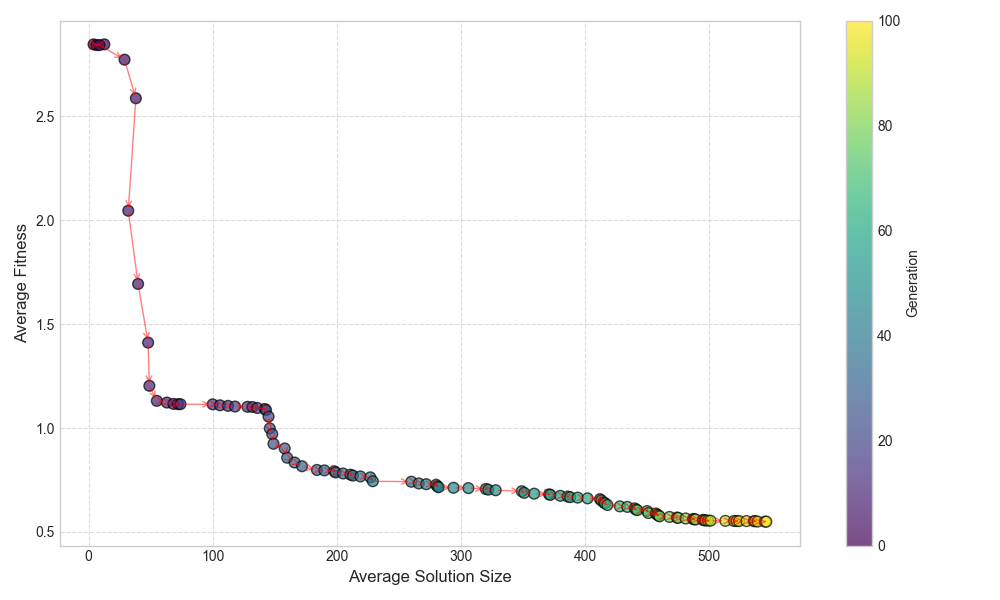

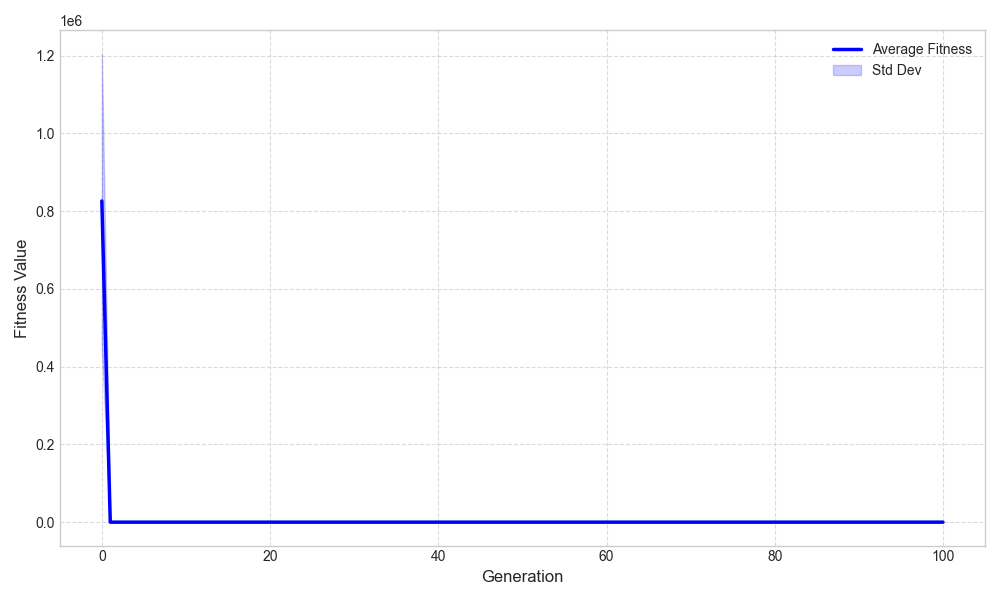

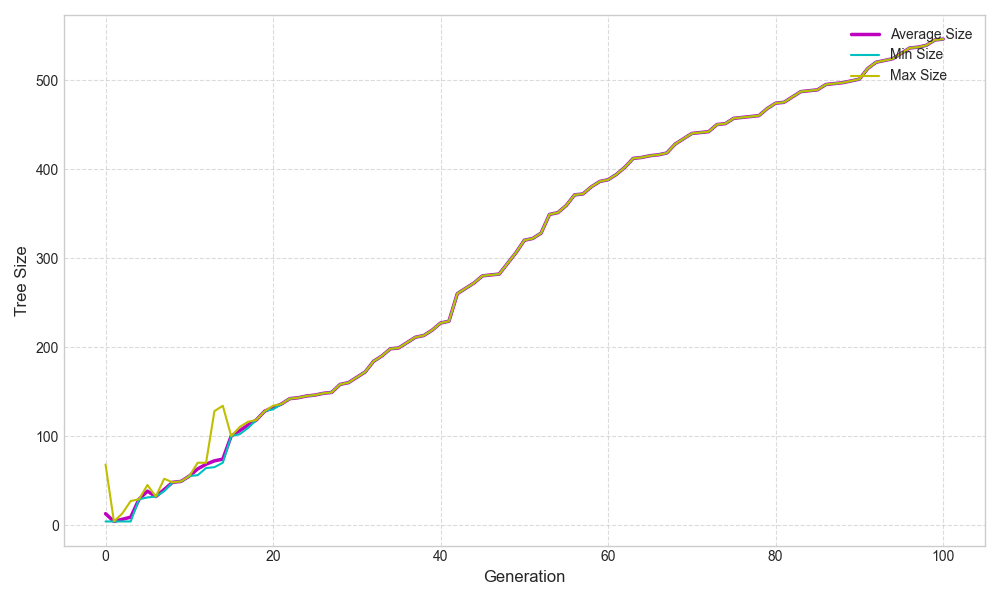

In [41]:
# Example usage
fig_fitness, fig_size, fig_correlation = plot_evolution_stats(
    logbook, 
    title="GP Boundary Approximation"
)

# You can save each figure separately
fig_fitness.savefig('./results/2d_2_fitness_evolution.png', dpi=300)
fig_size.savefig('./results/2d_2_size_evolution.png', dpi=300)
fig_correlation.savefig('./results/2d_2_size_fitness_correlation.png', dpi=300)

# Or display them
plt.show()

In [42]:
def plot_both_raw(exact_rfunc, approx_rfunc, n_theta=256, title="Exact vs. Approximate radial functions"):
    # Create figure
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    thetas = np.linspace(0, 2*np.pi, n_theta)

    # Calculate radius values
    exact_rvals = exact_rfunc(thetas)
    approx_rvals = approx_rfunc(thetas)

    
    # Exact solution - use a distinct blue
    ax1.plot(thetas, exact_rvals, color='#1E88E5', linestyle='--', linewidth=3, 
             label='Exact Solution', alpha=0.9)
    
    # Approximation - use a vibrant purple
    ax1.plot(thetas, approx_rvals, color='#8E24AA', linewidth=3, label='Approximation')
    
    # # Figure styling
    # ax1.set_aspect('equal')
    # ax1.grid(True, linestyle='--', alpha=0.6)
    # ax1.set_title(f"{title}", fontsize=15, pad=15)
    # ax1.set_xlabel('X', fontsize=13)
    # ax1.set_ylabel('Y', fontsize=13)
    
    # # Add legend with custom ordering (to match the visual layering)
    # handles, labels = ax1.get_legend_handles_labels()
    # order = [2, 0, 1]  # Reorder to: Outer, Exact, Approx
    # ax1.legend([handles[i] for i in order], [labels[i] for i in order], 
    #            loc='best', framealpha=0.9, fontsize=12)
    
    # # Apply tight layout
    # fig1.tight_layout()
    
    plt.show()
    
    return fig1

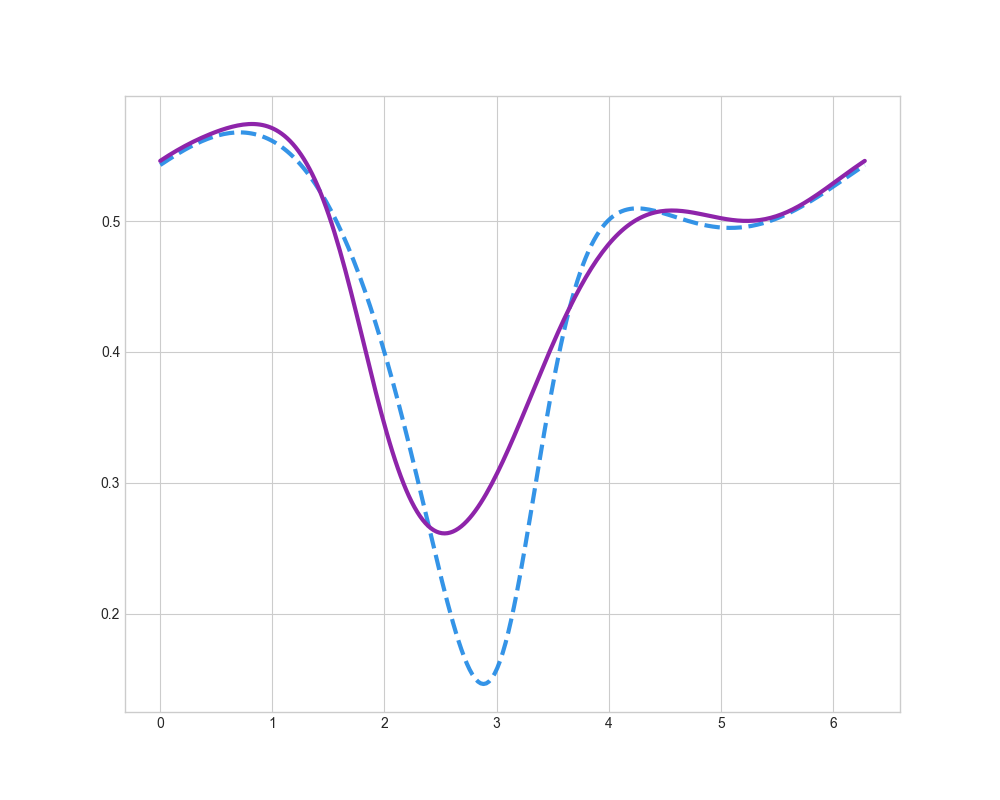

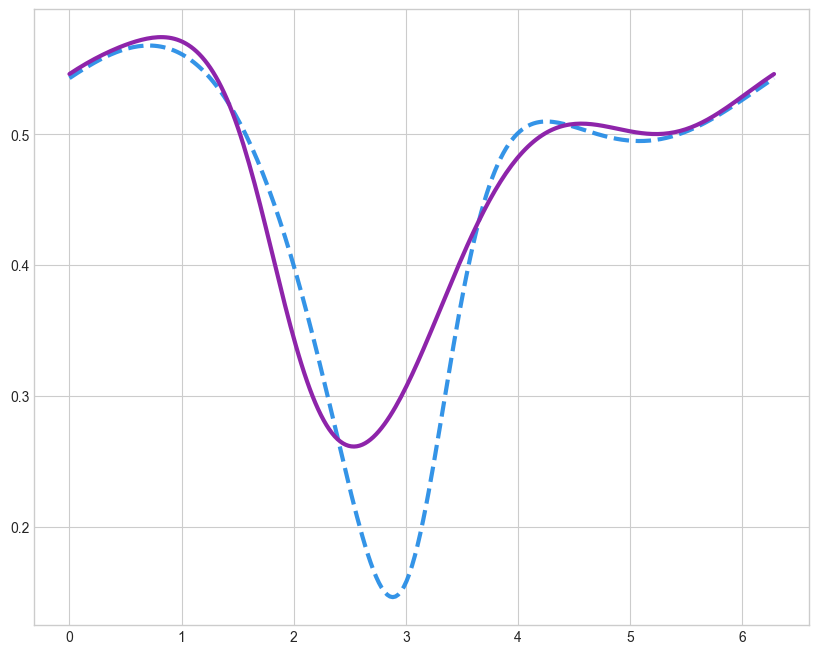

In [43]:
plot_both_raw(r1, toolbox.compile(expr=hof[0]))

In [47]:
s = np.linspace(0, 2*np.pi, 256)
exact_rvals = r1(s)
approx_rvals = toolbox.compile(expr=hof[0])(s)

# np.sqrt(integrate.trapezoid((exact_rvals-approx_rvals)**2, s)/integrate.trapezoid(exact_rvals, s))
np.sqrt(integrate.trapezoid((exact_rvals-approx_rvals)**2, s)/integrate.trapezoid(exact_rvals**2, s))

np.float64(0.1001731511014292)

In [49]:
approx_func = toolbox.compile(expr=hof[0])
np.sqrt(integrate.quad(lambda s: (r1(s) - approx_func(s))**2, 0, 2*np.pi)[0]/integrate.quad(lambda s: (approx_func(s))**2, 0, 2*np.pi)[0])

np.float64(0.0988275074982711)

In [46]:
diff_func = lambda s: r1(s) - toolbox.compile(expr=hof[0])(s)
integrate.quad()

TypeError: quad() missing 3 required positional arguments: 'func', 'a', and 'b'

In [ ]:
import pickle
with open("2d_2_logbook.pkl", "wb") as cp_file:
                pickle.dump(logbook, cp_file)

In [ ]:
assert False

In [ ]:
import matplotlib.pyplot as plt

def plot_g1(G1):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
toolbox.register('plot', plot_g1)

In [ ]:
from scipy import integrate
for ind in toolbox.population(n=50):
    ind_compile = toolbox.compile(expr=ind)
    ind_values = ind_compile(mfs_data.collocation.theta)
    print(ind)

    if not toolbox.feasable(ind_compile, ind_values):
        continue

    G1_test = StarlikeCurve.from_radial(mfs_data.collocation, ind_compile)
    g1_approx = toolbox.evaluate(ind_compile)
    print(toolbox.norm(g1_approx))
    toolbox.plot(G1_test)
    print('---------------------------------------------------------------------------')

In [ ]:
assert False

In [ ]:
import numpy as np

# Define the parametric function r(theta)
def r(theta):
    return np.sin(theta) + np.sin(0.11352607057693409)
    return np.sin(np.cos(2*theta))
    # sin(cos(add(s, s)))

    # Example: r(theta) = 1 + 0.5 * np.sin(5 * theta)
    return 1 + 0.5 * np.sin(5 * theta)

# Define the number of samples
num_samples = 1000

# Generate theta values
theta_values = np.linspace(0, 2 * np.pi, num_samples)

# Convert to Cartesian coordinates
x_values = r(theta_values) * np.cos(theta_values)
y_values = r(theta_values) * np.sin(theta_values)

# Check for intersections
tolerance = 1e-6
intersections = []

for i in range(num_samples):
    for j in range(i + 1, num_samples):
        if np.abs(x_values[i] - x_values[j]) < tolerance and np.abs(y_values[i] - y_values[j]) < tolerance:
            intersections.append((theta_values[i], theta_values[j]))

print("Self-intersections:", intersections)

In [ ]:
import sympy as sp

# Define the parameter
theta = sp.symbols('theta')

# Define the parametric equations for the starlike curve
r = sp.Function('r')(theta)
x = r * sp.cos(theta)
y = r * sp.sin(theta)

# Define another parameter for comparison
theta2 = sp.symbols('theta2')

# Equations for self-intersection
eq1 = sp.Eq(x.subs(theta, theta), x.subs(theta, theta2))
eq2 = sp.Eq(y.subs(theta, theta), y.subs(theta, theta2))

print("Equation 1:", eq1)
print("Equation 2:", eq2)

In [ ]:
ind = toolbox.individual()
print(ind)

In [ ]:
toolbox.compile(ind)(0)

In [ ]:
G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(ind))

In [ ]:
import matplotlib.pyplot as plt

fig_plot, ax_plot = plt.subplots()
g1_x, g1_y = G1_test.raw_points()
ax_plot.plot(g1_x, g1_y, 'b--')

ax_plot.axis('equal')
plt.grid()
plt.show()
plt.close()

In [ ]:
toolbox.evaluate(toolbox.compile(ind))[0]

In [ ]:
def r1(s):
    return 0.8

In [ ]:
def r1(s):
    return 0.8
exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [ ]:
np.linalg.norm(toolbox.evaluate(toolbox.compile(ind))-res)

In [ ]:
assert False

In [ ]:
from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
Gamma1 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r1, dr1)
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)

In [ ]:
Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1(s))
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))

In [ ]:
from gpbr.direct.common.source import SourcePoints2D
source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)

In [ ]:
## Plot
import matplotlib.pyplot as plt
def plot_2d(G1: StarlikeCurve, G2: StarlikeCurve, source):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    g2_x, g2_y = G2.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')
    ax_plot.plot(g2_x, g2_y, 'r--')

    for sp in source:
        ax_plot.plot(sp.x, sp.y, 'bo')

    # Plot normal vectors
    for p, n in zip(G1.points, G1.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='blue', scale=15)

    for p, n in zip(G2.points, G2.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='red', scale=15)

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
plot_2d(Gamma1, Gamma2, source_points)

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence

fundamental_sequence_gamma1 = fundamental_sequence_2d(Gamma1, source_points, mfs_data)
fundamental_sequence_gamma2 = fundamental_sequence_2d(Gamma2, source_points, mfs_data)

In [ ]:
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)
PHI_MAT.shape

In [ ]:
PHI_MAT

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs

alpha_coeeff = np.empty((N+1, M), dtype=np.float64)
alpha_coeeff[:] = np.nan
fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
from numpy.linalg import lstsq
for n in range(0, N+1):
    F = form_fs_vector_2d(n,
                          fundamental_sequence_gamma1,
                          fundamental_sequence_gamma2,
                          Gamma1,
                          Gamma2,
                          fs_coefs,
                          f1, f2, mfs_data)
    alpha_n = lstsq(PHI_MAT, F)[0]
    fs_coefs.alpha[n] = alpha_n.T
    print(fs_coefs.alpha)

In [ ]:
from gpbr.direct.common.boundary import Point2D
test_points = [Point2D(0.0, 0.98), Point2D(1.0, -0.73), Point2D(0.51, 0.54), Point2D(-0.501, 0.52), Point2D(-1.11, -0.75), Point2D(0.0, -1.0)]

In [ ]:
from gpbr.direct.heat_equation.helpers import u_2d
for n in range(0, N+1):
    print(f'N={n}')
    for p in test_points:
        u_approx = u_2d(p, n, source_points, fs_coefs, mfs_data)
        u_exact = u2de(p, mfs_data.tn[n])
        print(f'Difference: {abs(u_approx - u_exact)}')
        # print(f'u_approx={u_approx}, u_exact={u_exact}')

In [ ]:
def du2de_vec(xp, t):
    # -0.125*x1*exp((-x1**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    # 0.25*(2 - x2/2)*exp((-x1**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    return Point2D(
        -0.125*xp.x*np.exp((-xp.x**2/4 - (xp.y - 4)**2/4)/t)/(np.pi*t**2),
        0.25*(2 - xp.y/2)*np.exp((-xp.x**2/4 - (xp.y  - 4)**2/4)/t)/(np.pi*t**2)
    )
    

In [ ]:
from gpbr.direct.heat_equation.helpers import dbu_2d
for n in range(0, N+1):
    print(f'N={n}')
    norms = []
    for x, nx in zip(Gamma1.points, Gamma1.normals):
        du_approx = dbu_2d(x, nx, n, source_points, fs_coefs, mfs_data)
        du_e_vec = du2de_vec(x, mfs_data.tn[n])
        du_exact = du_e_vec.x*nx.x + du_e_vec.y*nx.y
        norms.append(abs(du_approx - du_exact))
    print(f'Max difference: {max(norms)}')
    # print(f'Max difference: {np.linalg.norm(norms)}')